In [1]:
# cd ../input/dip-dataset/FUnIE-GAN-master/FUnIE-GAN-master/PyTorch

In [2]:
# py libs
import os
import glob
import random
import sys
import yaml
import argparse
import numpy as np
from PIL import Image
# pytorch libs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.autograd as autograd

In [3]:
def Weights_Normal(m):
    # initialize weights as Normal(mean, std)
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [4]:
class VGG19_PercepLoss(nn.Module):
    """ Calculates perceptual loss in vgg19 space
    """
    def __init__(self, _pretrained_=True):
        super(VGG19_PercepLoss, self).__init__()
        self.vgg = models.vgg19(pretrained=_pretrained_).features
        for param in self.vgg.parameters():
            param.requires_grad_(False)

    def get_features(self, image, layers=None):
        if layers is None: 
            layers = {'30': 'conv5_2'} # may add other layers
        features = {}
        x = image
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
        return features

    def forward(self, pred, true, layer='conv5_2'):
        true_f = self.get_features(true)
        pred_f = self.get_features(pred)
        return torch.mean((true_f[layer]-pred_f[layer])**2)
    

class Gradient_Penalty(nn.Module):
    """ Calculates the gradient penalty loss for WGAN GP
    """
    def __init__(self, cuda=True):
        super(Gradient_Penalty, self).__init__()
        self.Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    def forward(self, D, real, fake):
        # Random weight term for interpolation between real and fake samples
        eps = self.Tensor(np.random.random((real.size(0), 1, 1, 1)))
        # Get random interpolation between real and fake samples
        interpolates = (eps * real + ((1 - eps) * fake)).requires_grad_(True)
        d_interpolates = D(interpolates)
        fake = autograd.Variable(self.Tensor(d_interpolates.shape).fill_(1.0), requires_grad=False)
        # Get gradient w.r.t. interpolates
        gradients = autograd.grad(outputs=d_interpolates,
                                  inputs=interpolates,
                                  grad_outputs=fake,
                                  create_graph=True,
                                  retain_graph=True,
                                  only_inputs=True,)[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty


In [5]:
# class UNetDown(nn.Module):
#     def __init__(self, in_size, out_size, bn=True):
#         super(UNetDown, self).__init__()
#         layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
#         if bn: layers.append(nn.BatchNorm2d(out_size, momentum=0.8))
#         layers.append(nn.LeakyReLU(0.2))
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)


# class UNetUp(nn.Module):
#     def __init__(self, in_size, out_size):
#         super(UNetUp, self).__init__()
#         layers = [
#             nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(out_size, momentum=0.8),
#             nn.ReLU(inplace=True),
#         ]
#         self.model = nn.Sequential(*layers)

#     def forward(self, x, skip_input):
#         x = self.model(x)
#         x = torch.cat((x, skip_input), 1)
#         return x

# class GeneratorFunieGAN(nn.Module):
#     """ A 5-layer UNet-based generator as described in the paper
#     """
#     def __init__(self, in_channels=3, out_channels=3):
#         super(GeneratorFunieGAN, self).__init__()
#         # encoding layers
#         self.down1 = UNetDown(in_channels, 32, bn=False)
#         self.down2 = UNetDown(32, 128)
#         self.down3 = UNetDown(128, 256)
#         self.down4 = UNetDown(256, 256)
#         self.down5 = UNetDown(256, 256, bn=False)
#         # decoding layers
#         self.up1 = UNetUp(256, 256)
#         self.up2 = UNetUp(512, 256)
#         self.up3 = UNetUp(512, 128)
#         self.up4 = UNetUp(256, 32)
#         self.final = nn.Sequential(
#             nn.Upsample(scale_factor=2),
#             nn.ZeroPad2d((1, 0, 1, 0)),
#             nn.Conv2d(64, out_channels, 4, padding=1),
#             nn.Tanh(),
#         )

#     def forward(self, x):
#         d1 = self.down1(x)
#         d2 = self.down2(d1)
#         d3 = self.down3(d2)
#         d4 = self.down4(d3)
#         d5 = self.down5(d4)
#         u1 = self.up1(d5, d4)
#         u2 = self.up2(u1, d3)
#         u3 = self.up3(u2, d2)
#         u45 = self.up4(u3, d1)
#         return self.final(u45)


# class DiscriminatorFunieGAN(nn.Module):
#     """ A 4-layer Markovian discriminator as described in the paper
#     """
#     def __init__(self, in_channels=3):
#         super(DiscriminatorFunieGAN, self).__init__()

#         def discriminator_block(in_filters, out_filters, bn=True):
#             #Returns downsampling layers of each discriminator block
#             layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
#             if bn: layers.append(nn.BatchNorm2d(out_filters, momentum=0.8))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *discriminator_block(in_channels*2, 32, bn=False),
#             *discriminator_block(32, 64),
#             *discriminator_block(64, 128),
#             *discriminator_block(128, 256),
#             nn.ZeroPad2d((1, 0, 1, 0)),
#             nn.Conv2d(256, 1, 4, padding=1, bias=False)
#         )

#     def forward(self, img_A, img_B):
#         # Concatenate image and condition image by channels to produce input
#         img_input = torch.cat((img_A, img_B), 1)
#         return self.model(img_input)


In [6]:
# Elif's code

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, bn=True):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if bn: layers.append(nn.BatchNorm2d(out_size, momentum=0.8))
        layers.append(nn.LeakyReLU(0.2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UNetUp(nn.Module):
    def __init__(self, in_size, out_size):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_size, momentum=0.8),
            nn.ReLU(inplace=True),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class GeneratorFunieGAN(nn.Module):
    """ A 5-layer UNet-based generator as described in the paper
    """
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorFunieGAN, self).__init__()
        # encoding layers
        self.down1 = UNetDown(in_channels, 32, bn=False)
        self.down2 = UNetDown(32, 64) #64
        self.down3 = UNetDown(64, 128) #64
        self.down4 = UNetDown(128, 128)#64
        self.down5 = UNetDown(128, 128, bn=False) #64
        # decoding layers
        self.up1 = UNetUp(128, 128) #64
        self.up2 = UNetUp(256, 128) #64
        self.up3 = UNetUp(256, 64) #64
        self.up4 = UNetUp(128, 32)  #64
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(64, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        u1 = self.up1(d5, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u45 = self.up4(u3, d1)
        return self.final(u45)


class DiscriminatorFunieGAN(nn.Module):
    """ A 4-layer Markovian discriminator as described in the paper
    """
    def __init__(self, in_channels=3):
        super(DiscriminatorFunieGAN, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            #Returns downsampling layers of each discriminator block
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if bn: layers.append(nn.BatchNorm2d(out_filters, momentum=0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels*2, 32, bn=False),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(256, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [7]:
class GetTrainingPairs(Dataset):
    """ Common data pipeline to organize and generate
         training pairs for various datasets   
    """
    def __init__(self, root, dataset_name, transforms_=None):
        self.transform = transforms.Compose(transforms_)
        self.filesA, self.filesB = self.get_file_paths(root, dataset_name)
        self.len = min(len(self.filesA), len(self.filesB))

    def __getitem__(self, index):
        img_A = Image.open(self.filesA[index % self.len])
        img_B = Image.open(self.filesB[index % self.len])
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")
        img_A = self.transform(img_A)
        img_B = self.transform(img_B)
        return {"A": img_A, "B": img_B}

    def __len__(self):
        return self.len

    def get_file_paths(self, root, dataset_name):
        if dataset_name=='EUVP':
            filesA, filesB = [], []
            sub_dirs = ['image1', 'dark1', 'scenes1']
            for sd in sub_dirs:
                filesA += sorted(glob.glob(os.path.join(root, sd, 'trainA') + "/*.*"))
                filesB += sorted(glob.glob(os.path.join(root, sd, 'trainB') + "/*.*"))
        elif dataset_name=='UFO-120':
                filesA = sorted(glob.glob(os.path.join(root, 'lrd') + "/*.*"))
                filesB = sorted(glob.glob(os.path.join(root, 'hr') + "/*.*"))
        return filesA, filesB 



class GetValImage(Dataset):
    """ Common data pipeline to organize and generate
         vaditaion samples for various datasets   
    """
    def __init__(self, root, dataset_name, transforms_=None, sub_dir='validation'):
        self.transform = transforms.Compose(transforms_)
        self.files = self.get_file_paths(root, dataset_name)
        self.len = len(self.files)

    def __getitem__(self, index):
        img_val = Image.open(self.files[index % self.len])
        img_val = self.transform(img_val)
        return {"val": img_val}

    def __len__(self):
        return self.len

    def get_file_paths(self, root, dataset_name):
        if dataset_name=='EUVP':
            files = []
            sub_dirs = ['image1', 'dark1', 'scenes1']
            for sd in sub_dirs:
                files += sorted(glob.glob(os.path.join(root, sd, 'validation') + "/*.*"))
        elif dataset_name=='UFO-120':
            files = sorted(glob.glob(os.path.join(root, 'lrd') + "/*.*"))
        return files

## Train

In [8]:
# !pip install -U PyYAML

In [9]:
## training params
epoch = 0
num_epochs = 71
batch_size =  8
lr_rate, lr_b1, lr_b2 = 0.0003, 0.5, 0.99 
# # load the data config file
# with open(args.cfg_file) as f:
#     cfg = yaml.load(f, Loader=yaml.FullLoader)
# get info from config file
dataset_name = "EUVP"
dataset_path = "../input/dip-dataset/dip_dataset"
channels = 3
img_width = 256
img_height = 256 
val_interval = 1000
ckpt_interval = 10

## create dir for model and validation data
samples_dir = os.path.join("./samples/FunieGAN/", dataset_name)
checkpoint_dir = os.path.join("./checkpoints/FunieGAN/", dataset_name)
os.makedirs(samples_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

In [10]:
""" FunieGAN specifics: loss functions and patch-size
-----------------------------------------------------"""
Adv_cGAN = torch.nn.MSELoss()
L1_G  = torch.nn.L1Loss() # similarity loss (l1)
L_vgg = VGG19_PercepLoss() # content loss (vgg)
lambda_1, lambda_con = 7, 3 # 7:3 (as in paper)
patch = (1, img_height//16, img_width//16) # 16x16 for 256x256

# Initialize generator and discriminator
generator = GeneratorFunieGAN()
discriminator = DiscriminatorFunieGAN()

# see if cuda is available
if torch.cuda.is_available():
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    Adv_cGAN.cuda()
    L1_G = L1_G.cuda()
    L_vgg = L_vgg.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    Tensor = torch.FloatTensor

# Initialize weights or load pretrained models
if epoch == 0:
    generator.apply(Weights_Normal)
    discriminator.apply(Weights_Normal)
else:
    generator.load_state_dict(torch.load("checkpoints/FunieGAN/%s/generator_%d.pth" % (dataset_name, args.epoch)))
    discriminator.load_state_dict(torch.load("checkpoints/FunieGAN/%s/discriminator_%d.pth" % (dataset_name, epoch)))
    print ("Loaded model from epoch %d" %(epoch))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate, betas=(lr_b1, lr_b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_rate, betas=(lr_b1, lr_b2))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [11]:
## Data pipeline
transforms_ = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    GetTrainingPairs(dataset_path, dataset_name, transforms_=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2,
)

val_dataloader = DataLoader(
    GetValImage(dataset_path, dataset_name, transforms_=transforms_, sub_dir='validation'),
    batch_size=4,
    shuffle=True,
    num_workers=1,
)


## Training pipeline
for epoch in range(epoch, num_epochs):
    for i, batch in enumerate(dataloader):
        # Model inputs
        imgs_distorted = Variable(batch["A"].type(Tensor))
        imgs_good_gt = Variable(batch["B"].type(Tensor))
        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_distorted.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_distorted.size(0), *patch))), requires_grad=False)

        ## Train Discriminator
        optimizer_D.zero_grad()
        imgs_fake = generator(imgs_distorted)
        pred_real = discriminator(imgs_good_gt, imgs_distorted)
        loss_real = Adv_cGAN(pred_real, valid)
        pred_fake = discriminator(imgs_fake, imgs_distorted)
        loss_fake = Adv_cGAN(pred_fake, fake)
        # Total loss: real + fake (standard PatchGAN)
        loss_D = 0.5 * (loss_real + loss_fake) * 10.0 # 10x scaled for stability
        loss_D.backward()
        optimizer_D.step()

        ## Train Generator
        optimizer_G.zero_grad()
        imgs_fake = generator(imgs_distorted)
        pred_fake = discriminator(imgs_fake, imgs_distorted)
        loss_GAN =  Adv_cGAN(pred_fake, valid) # GAN loss
        loss_1 = L1_G(imgs_fake, imgs_good_gt) # similarity loss
        loss_con = L_vgg(imgs_fake, imgs_good_gt)# content loss
        # Total loss (Section 3.2.1 in the paper)
        loss_G = loss_GAN + lambda_1 * loss_1  + lambda_con * loss_con 
        loss_G.backward()
        optimizer_G.step()

        ## Print log
        if not i%50:
            sys.stdout.write("\r[Epoch %d/%d: batch %d/%d] [DLoss: %.3f, GLoss: %.3f, AdvLoss: %.3f]"
                              %(
                                epoch, num_epochs, i, len(dataloader),
                                loss_D.item(), loss_G.item(), loss_GAN.item(),
                               )
            )
        ## If at sample interval save image
        batches_done = epoch * len(dataloader) + i
        if batches_done % val_interval == 0:
            imgs = next(iter(val_dataloader))
            imgs_val = Variable(imgs["val"].type(Tensor))
            imgs_gen = generator(imgs_val)
            img_sample = torch.cat((imgs_val.data, imgs_gen.data), -2)
            save_image(img_sample, "samples/FunieGAN/%s/%s.png" % (dataset_name, batches_done), nrow=5, normalize=True)

    ## Save model checkpoints
    if (epoch % ckpt_interval == 0):
        torch.save(generator.state_dict(), "checkpoints/FunieGAN/%s/generator_%d.pth" % (dataset_name, epoch))
        torch.save(discriminator.state_dict(), "checkpoints/FunieGAN/%s/discriminator_%d.pth" % (dataset_name, epoch))

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


[Epoch 70/71: batch 1200/1242] [DLoss: 0.050, GLoss: 3.670, AdvLoss: 1.034]

## Test

In [12]:
# py libs
import os
import time
import argparse
import numpy as np
from PIL import Image
from glob import glob
from ntpath import basename
from os.path import join, exists
# pytorch libs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms

In [13]:
# Select model weights saved after nth epoch 
dataset_name = "EUVP"
epoch = 70

In [14]:
sample_dir = "data/dark1/"  #output samples
data_dir = "../input/dip-dataset/dip_dataset/dark1/testA"   #test folder
model_path = "checkpoints/FunieGAN/%s/generator_%d.pth" % (dataset_name, epoch) #saved model weights .pth

# pretrained weights
# model_path = "../input/dip-dataset/FUnIE-GAN-master/FUnIE-GAN-master/PyTorch/models/funie_generator.pth"

os.makedirs(sample_dir, exist_ok=True)
is_cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor 

model = GeneratorFunieGAN()

## load weights
model.load_state_dict(torch.load(model_path))
if is_cuda: model.cuda()
model.eval()
print ("Loaded model from %s" % (model_path))

## data pipeline
img_width, img_height, channels = 256, 256, 3
transforms_ = [transforms.Resize((img_height, img_width), Image.BICUBIC),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
transform = transforms.Compose(transforms_)

## testing loop
times = []
test_files = sorted(glob(join(data_dir, "*.*")))
for path in test_files:
    inp_img = transform(Image.open(path))
    inp_img = Variable(inp_img).type(Tensor).unsqueeze(0)
    # generate enhanced image
    s = time.time()
    gen_img = model(inp_img)
    times.append(time.time()-s)
    # save output
    img_sample = torch.cat((inp_img.data, gen_img.data), -1)
    save_image(img_sample, join(sample_dir, basename(path)), normalize=True)
#     print ("Tested: %s" % path)

## run-time    
if (len(times) > 1):
    print ("\nTotal samples: %d" % len(test_files)) 
    # accumulate frame processing times (without bootstrap)
    Ttime, Mtime = np.sum(times[1:]), np.mean(times[1:]) 
    print ("Time taken: %d sec at %0.3f fps" %(Ttime, 1./Mtime))
    print("Saved generated images in in %s\n" %(sample_dir))

Loaded model from checkpoints/FunieGAN/EUVP/generator_70.pth

Total samples: 500
Time taken: 1 sec at 484.906 fps
Saved generated images in in data/dark1/



In [15]:
sample_dir = "data/image1/"  #output samples
data_dir = "../input/dip-dataset/dip_dataset/image1/testA"   #test folder
model_path = "checkpoints/FunieGAN/%s/generator_%d.pth" % (dataset_name, epoch) #saved model weights .pth

# pretrained weights
# model_path = "../input/dip-dataset/FUnIE-GAN-master/FUnIE-GAN-master/PyTorch/models/funie_generator.pth"

os.makedirs(sample_dir, exist_ok=True)
is_cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor 

model = GeneratorFunieGAN()

## load weights
model.load_state_dict(torch.load(model_path))
if is_cuda: model.cuda()
model.eval()
print ("Loaded model from %s" % (model_path))

## data pipeline
img_width, img_height, channels = 256, 256, 3
transforms_ = [transforms.Resize((img_height, img_width), Image.BICUBIC),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
transform = transforms.Compose(transforms_)

## testing loop
times = []
test_files = sorted(glob(join(data_dir, "*.*")))
for path in test_files:
    inp_img = transform(Image.open(path))
    inp_img = Variable(inp_img).type(Tensor).unsqueeze(0)
    # generate enhanced image
    s = time.time()
    gen_img = model(inp_img)
    times.append(time.time()-s)
    # save output
    img_sample = torch.cat((inp_img.data, gen_img.data), -1)
    save_image(img_sample, join(sample_dir, basename(path)), normalize=True)
#     print ("Tested: %s" % path)

## run-time    
if (len(times) > 1):
    print ("\nTotal samples: %d" % len(test_files)) 
    # accumulate frame processing times (without bootstrap)
    Ttime, Mtime = np.sum(times[1:]), np.mean(times[1:]) 
    print ("Time taken: %d sec at %0.3f fps" %(Ttime, 1./Mtime))
    print("Saved generated images in in %s\n" %(sample_dir))

Loaded model from checkpoints/FunieGAN/EUVP/generator_70.pth

Total samples: 500
Time taken: 0 sec at 502.484 fps
Saved generated images in in data/image1/



In [16]:
sample_dir = "data/scenes1/"  #output samples
data_dir = "../input/dip-dataset/dip_dataset/scenes1/testA"   #test folder
model_path = "checkpoints/FunieGAN/%s/generator_%d.pth" % (dataset_name, epoch) #saved model weights .pth

# pretrained weights
# model_path = "../input/dip-dataset/FUnIE-GAN-master/FUnIE-GAN-master/PyTorch/models/funie_generator.pth"

os.makedirs(sample_dir, exist_ok=True)
is_cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if is_cuda else torch.FloatTensor 

model = GeneratorFunieGAN()

## load weights
model.load_state_dict(torch.load(model_path))
if is_cuda: model.cuda()
model.eval()
print ("Loaded model from %s" % (model_path))

## data pipeline
img_width, img_height, channels = 256, 256, 3
transforms_ = [transforms.Resize((img_height, img_width), Image.BICUBIC),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
transform = transforms.Compose(transforms_)

## testing loop
times = []
test_files = sorted(glob(join(data_dir, "*.*")))
for path in test_files:
    inp_img = transform(Image.open(path))
    inp_img = Variable(inp_img).type(Tensor).unsqueeze(0)
    # generate enhanced image
    s = time.time()
    gen_img = model(inp_img)
    times.append(time.time()-s)
    # save output
    img_sample = torch.cat((inp_img.data, gen_img.data), -1)
    save_image(img_sample, join(sample_dir, basename(path)), normalize=True)
#     print ("Tested: %s" % path)

## run-time    
if (len(times) > 1):
    print ("\nTotal samples: %d" % len(test_files)) 
    # accumulate frame processing times (without bootstrap)
    Ttime, Mtime = np.sum(times[1:]), np.mean(times[1:]) 
    print ("Time taken: %d sec at %0.3f fps" %(Ttime, 1./Mtime))
    print("Saved generated images in in %s\n" %(sample_dir))

Loaded model from checkpoints/FunieGAN/EUVP/generator_70.pth

Total samples: 500
Time taken: 1 sec at 486.588 fps
Saved generated images in in data/scenes1/



## Metrics

In [17]:
import skimage
import skimage.color
from skimage.metrics import structural_similarity as SSIM
from math import log10, sqrt
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def UCIQE(img, c1=0.4680, c2=0.2745, c3=0.2576):
    # rgb = a
    # a = a/255
    
    lab = skimage.color.rgb2lab(img)
    # lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # gray = skimage.color.rgb2gray(a)
    # UCIQE
    l = lab[:,:,0]

    #1st term
    chroma = (lab[:,:,1]**2 + lab[:,:,2]**2)**0.5
    uc = np.mean(chroma)
    sc = (np.mean((chroma - uc)**2))**0.5

    #2nd term
    top = np.int(np.round(0.01*l.shape[0]*l.shape[1]))
    sl = np.sort(l,axis=None)
    isl = sl[::-1]
    conl = np.mean(isl[::top])-np.mean(sl[::top])

    #3rd term
    satur = []
    chroma1 = chroma.flatten()
    l1 = l.flatten()
    for i in range(len(l1)):
        if chroma1[i] == 0: satur.append(0)
        elif l1[i] == 0: satur.append(0)
        else: satur.append(chroma1[i] / l1[i])

    us = np.mean(satur)

    UCIQE = c1 * sc + c2 * conl + c3 * us
    return UCIQE

In [19]:
"""
# > Modules for computing the Underwater Image Quality Measure (UIQM)
# Maintainer: Jahid (email: islam034@umn.edu)
"""
from scipy import ndimage
from PIL import Image
import math

def mu_a(x, alpha_L=0.1, alpha_R=0.1):
    """
      Calculates the asymetric alpha-trimmed mean
    """
    # sort pixels by intensity - for clipping
    x = sorted(x)
    # get number of pixels
    K = len(x)
    # calculate T alpha L and T alpha R
    T_a_L = math.ceil(alpha_L*K)
    T_a_R = math.floor(alpha_R*K)
    # calculate mu_alpha weight
    weight = (1/(K-T_a_L-T_a_R))
    # loop through flattened image starting at T_a_L+1 and ending at K-T_a_R
    s   = int(T_a_L+1)
    e   = int(K-T_a_R)
    val = sum(x[s:e])
    val = weight*val
    return val

def s_a(x, mu):
    val = 0
    for pixel in x:
        val += math.pow((pixel-mu), 2)
    return val/len(x)

def _uicm(x):
    R = x[:,:,0].flatten()
    G = x[:,:,1].flatten()
    B = x[:,:,2].flatten()
    RG = R-G
    YB = ((R+G)/2)-B
    mu_a_RG = mu_a(RG)
    mu_a_YB = mu_a(YB)
    s_a_RG = s_a(RG, mu_a_RG)
    s_a_YB = s_a(YB, mu_a_YB)
    l = math.sqrt( (math.pow(mu_a_RG,2)+math.pow(mu_a_YB,2)) )
    r = math.sqrt(s_a_RG+s_a_YB)
    return (-0.0268*l)+(0.1586*r)

def sobel(x):
    dx = ndimage.sobel(x,0)
    dy = ndimage.sobel(x,1)
    mag = np.hypot(dx, dy)
    mag *= 255.0 / np.max(mag) 
    return mag

def eme(x, window_size):
    """
      Enhancement measure estimation
      x.shape[0] = height
      x.shape[1] = width
    """
    # if 4 blocks, then 2x2...etc.
    k1 = int(x.shape[1]/window_size)
    k2 = int(x.shape[0]/window_size)
    # weight
    w = 2./(k1*k2)
    blocksize_x = window_size
    blocksize_y = window_size
    # make sure image is divisible by window_size - doesn't matter if we cut out some pixels
    x = x[:blocksize_y*k2, :blocksize_x*k1]
    val = 0
    for l in range(k1):
        for k in range(k2):
            block = x[k*window_size:window_size*(k+1), l*window_size:window_size*(l+1)]
            max_ = np.max(block)
            min_ = np.min(block)
            # bound checks, can't do log(0)
            if min_ == 0.0: val += 0
            elif max_ == 0.0: val += 0
            else: val += math.log(max_/min_)
    return w*val

def _uism(x):
    """
      Underwater Image Sharpness Measure
    """
    # get image channels
    R = x[:,:,0]
    G = x[:,:,1]
    B = x[:,:,2]
    # first apply Sobel edge detector to each RGB component
    Rs = sobel(R)
    Gs = sobel(G)
    Bs = sobel(B)
    # multiply the edges detected for each channel by the channel itself
    R_edge_map = np.multiply(Rs, R)
    G_edge_map = np.multiply(Gs, G)
    B_edge_map = np.multiply(Bs, B)
    # get eme for each channel
    r_eme = eme(R_edge_map, 10)
    g_eme = eme(G_edge_map, 10)
    b_eme = eme(B_edge_map, 10)
    # coefficients
    lambda_r = 0.299
    lambda_g = 0.587
    lambda_b = 0.144
    return (lambda_r*r_eme) + (lambda_g*g_eme) + (lambda_b*b_eme)

def plip_g(x,mu=1026.0):
    return mu-x

def plip_theta(g1, g2, k):
    g1 = plip_g(g1)
    g2 = plip_g(g2)
    return k*((g1-g2)/(k-g2))

def plip_cross(g1, g2, gamma):
    g1 = plip_g(g1)
    g2 = plip_g(g2)
    return g1+g2-((g1*g2)/(gamma))

def plip_diag(c, g, gamma):
    g = plip_g(g)
    return gamma - (gamma * math.pow((1 - (g/gamma) ), c) )

def plip_multiplication(g1, g2):
    return plip_phiInverse(plip_phi(g1) * plip_phi(g2))
    #return plip_phiInverse(plip_phi(plip_g(g1)) * plip_phi(plip_g(g2)))

def plip_phiInverse(g):
    plip_lambda = 1026.0
    plip_beta   = 1.0
    return plip_lambda * (1 - math.pow(math.exp(-g / plip_lambda), 1 / plip_beta));

def plip_phi(g):
    plip_lambda = 1026.0
    plip_beta   = 1.0
    return -plip_lambda * math.pow(math.log(1 - g / plip_lambda), plip_beta)

def _uiconm(x, window_size):
    """
      Underwater image contrast measure
      https://github.com/tkrahn108/UIQM/blob/master/src/uiconm.cpp
      https://ieeexplore.ieee.org/abstract/document/5609219
    """
    plip_lambda = 1026.0
    plip_gamma  = 1026.0
    plip_beta   = 1.0
    plip_mu     = 1026.0
    plip_k      = 1026.0
    # if 4 blocks, then 2x2...etc.
    k1 = int(x.shape[1]/window_size)
    k2 = int(x.shape[0]/window_size)
    # weight
    w = -1./(k1*k2)
    blocksize_x = window_size
    blocksize_y = window_size
    # make sure image is divisible by window_size - doesn't matter if we cut out some pixels
    x = x[:blocksize_y*k2, :blocksize_x*k1]
    # entropy scale - higher helps with randomness
    alpha = 1
    val = 0
    for l in range(k1):
        for k in range(k2):
            block = x[k*window_size:window_size*(k+1), l*window_size:window_size*(l+1), :]
            max_ = np.max(block)
            min_ = np.min(block)
            top = max_-min_
            bot = max_+min_
            if math.isnan(top) or math.isnan(bot) or bot == 0.0 or top == 0.0: val += 0.0
            else: val += alpha*math.pow((top/bot),alpha) * math.log(top/bot)
            #try: val += plip_multiplication((top/bot),math.log(top/bot))
    return w*val

def UIQM(x):
    """
      Function to return UIQM to be called from other programs
      x: image
    """
    x = x.astype(np.float32)
    ### UCIQE: https://ieeexplore.ieee.org/abstract/document/7300447
    #c1 = 0.4680; c2 = 0.2745; c3 = 0.2576
    ### UIQM https://ieeexplore.ieee.org/abstract/document/7305804
    c1 = 0.0282; c2 = 0.2953; c3 = 3.5753
    uicm   = _uicm(x)
    uism   = _uism(x)
    uiconm = _uiconm(x, 10)
    uiqm = (c1*uicm) + (c2*uism) + (c3*uiconm)
    return uiqm

# print(skimage.metrics.structural_similarity(img1,img2,multichannel=True,
#                                             gaussian_weights = True,
#                                             sigma = 1.5,
#                                             use_sample_covariance= False))
# print(skimage.metrics.structural_similarity(output,img2,multichannel=True,
#                                             gaussian_weights = True,
#                                             sigma = 1.5,
#                                             use_sample_covariance= False))

In [20]:
def print_metrics(img1,output,img2, show = True):
    """
    input, output, ground truth
    show:
    -True: displays table
    -False: returns matrix
    """

    metrics = np.zeros((4,3))
    metrics[0,:] = np.array([PSNR(img1, img2),
                             PSNR(output, img2),
                             PSNR(img2, img2)])
    metrics[1,:] = np.array([SSIM(img1, img2, multichannel=True),
                             SSIM(output, img2, multichannel=True),
                             SSIM(img2, img2, multichannel=True)])
    metrics[2,:] = np.array([UCIQE(img1),UCIQE(output),UCIQE(img2)])
    metrics[3,:] = np.array([UIQM(img1),UIQM(output),UIQM(img2)])

    if(show == True):
        df_metrics = metrics_table(metrics)
        display(df_metrics.astype(float).round(decimals=4))

    else:
        return metrics
    
# def PSNR(original, compressed):
#     mse = np.mean((original - compressed) ** 2)
#     if(mse == 0):  # MSE is zero means no noise is present in the signal .
#                   # Therefore PSNR have no importance.
#         return np.inf
#     max_pixel = 255.0
#     psnr = 20 * log10(max_pixel / sqrt(mse))
#     return psnr

def PSNR(
        im_1: np.ndarray,
        im_2: np.ndarray,
        max_signal_value = 255.0,
        ) -> float:
    """Calculates the **peak signal-to-noise ratio** between two images in dB

    Calculates the peak signal-to-noise ratio in decibels between two input
    images. The ratio is defined as -20 * log\ :subscript:`10`\ 
    (max_signal_value / X) where max_signal_value is the maximum possible 
    value in either image and X is the mean of all elements in the ndarray 
    (im_1 - im_2)\ :superscript:`2`\ . The two images must have the same 
    dtype.
    
    If max_signal_value is not specified and the two images have unsigned 
    integer dtype, then max_signal_value is assumed to be the largest value 
    possible in the dtype. If max_signal_value is not specified and the two 
    images have float dtype and all their values are between 0.0 and 1.0 
    inclusive, then max_signal_value is assumed to be 1.0.

    :type im_1: ``numpy.ndarray``
    :param im_1: An image to be compared.
    :type im_2: ``numpy.ndarray``
    :param im_2: An image to be compared.
    :type max_signal_value: ``int`` or ``float``
    :param max_signal_value: (Optional) The maximum *possible* signal value in 
        either image. (This is not necessarily the maximum value of either 
        image).
    :rtype: ``float``
    :return: The decibel peak signal-to-noise ratio.

    Examples:

    >>> import numpy as np
    >>> im = np.array([[0.5  , 0.125],
    ...                [0.25 , 0.   ]])
    >>> im_2 = im / 2
    >>> PSNR(im, im_2)
    16.880806619058927
    >>> im = np.array([[100,  20],
    ...                [ 40,   0]])
    >>> im_2 = im / 2
    >>> PSNR(im, im_2, 255)
    19.380190974762105
    """
    assert im_1.dtype == im_2.dtype, "The two images must have the same dtype"
    if max_signal_value is None:
        float_cond = 'f' == im_1.dtype.kind and \
                     1.0 >= max(np.max(im_1), np.max(im_2)) and \
                     0.0 <= min(np.min(im_1), np.min(im_2))
        assert float_cond or 'u' == im_1.dtype.kind, \
                "Without a specified max_signal_value, the PSNR can only be " \
                "calculated for images with unsigned integer dtypes or " \
                "float dtypes with values normalized between 0.0 and 1.0. " \
                "Please either specify a max_signal_value or convert the " \
                "images to an unsigned integer dtype."
        if float_cond:
            max_signal_value = 1.0
        else:
            max_signal_value = np.iinfo(im_1.dtype).max
    error_diff = im_1 - im_2
    if np.all(0 == error_diff):
        return float('inf')
    return 10 * np.log10(max_signal_value ** 2 / np.mean(error_diff ** 2))

def metrics_table(metrics):
    df_metrics = pd.DataFrame(index=['PSNR','SSIM','UCIQE','UIQM'],
                            columns=['Input','Output','Ground Truth'])
    df_metrics.at['PSNR'] = metrics[0,:]
    df_metrics.at['SSIM'] = metrics[1,:]
    df_metrics.at['UCIQE'] = metrics[2,:]
    df_metrics.at['UIQM'] = metrics[3,:]
    return df_metrics

def plot_images(img1,output,img2):
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(img1); plt.axis('off')
    plt.title('Original')
    plt.subplot(132)    
    plt.imshow(output); plt.axis('off')
    plt.title('Result')
    plt.subplot(133)    
    plt.imshow(img2); plt.axis('off')
    plt.title('Ground Truth')
    plt.show()

In [21]:
root = "../input/dip-dataset/dip_dataset"
folder_list = ["dark1","image1"]

files = {}
for f in folder_list:
    files[f] = sorted(os.listdir(os.path.join(root,f,"testB")))
    print(f, ":",len(files[f]))

dark1 : 500
image1 : 500


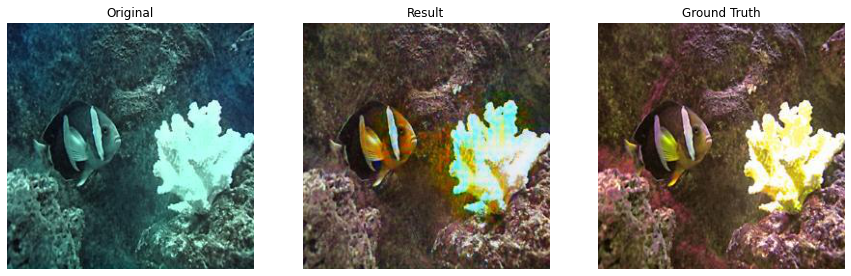

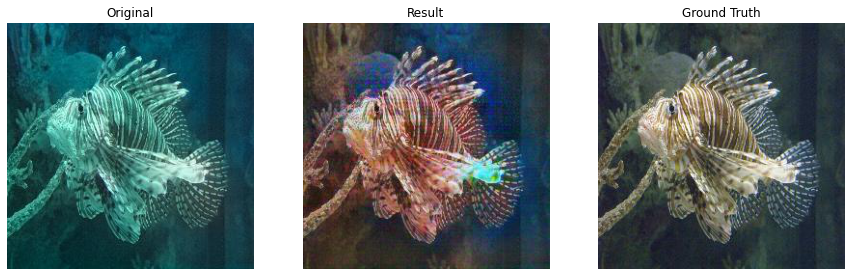

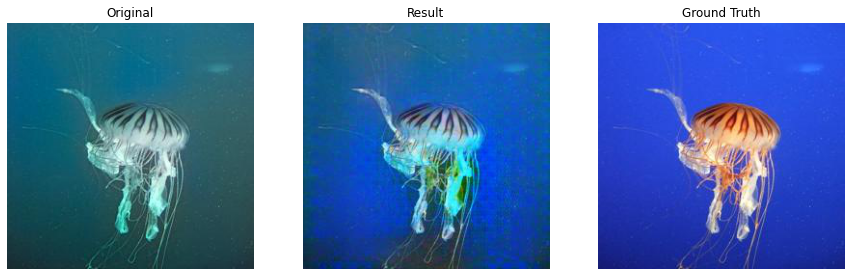

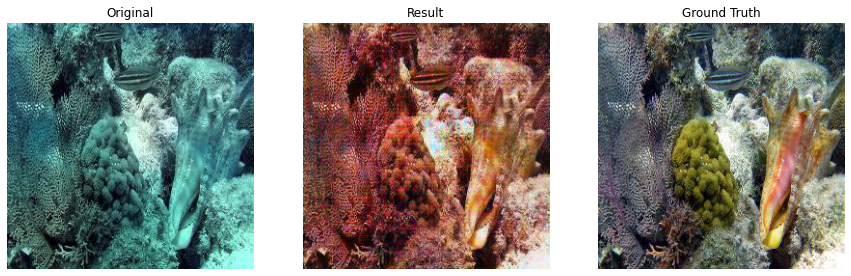

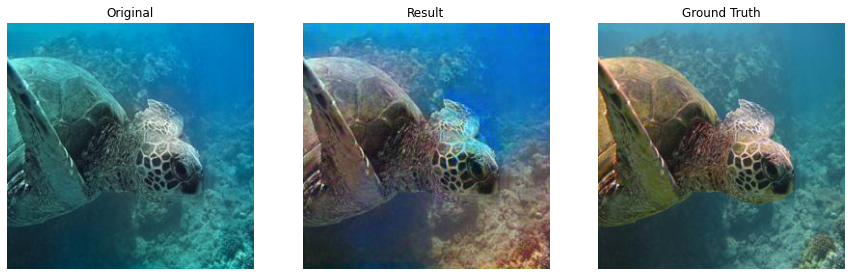

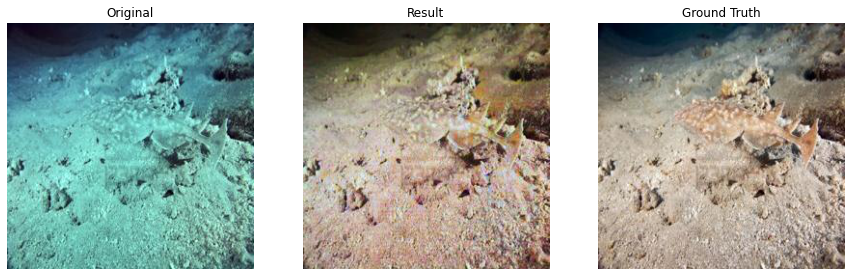

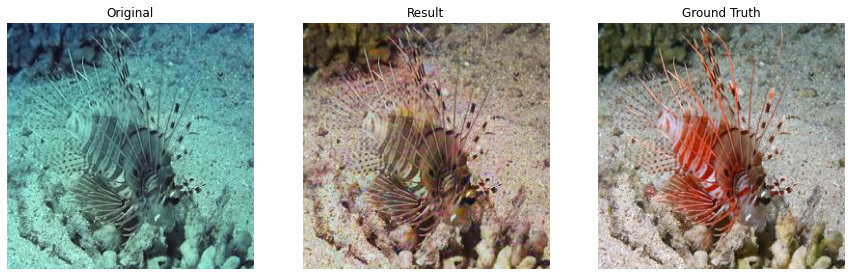

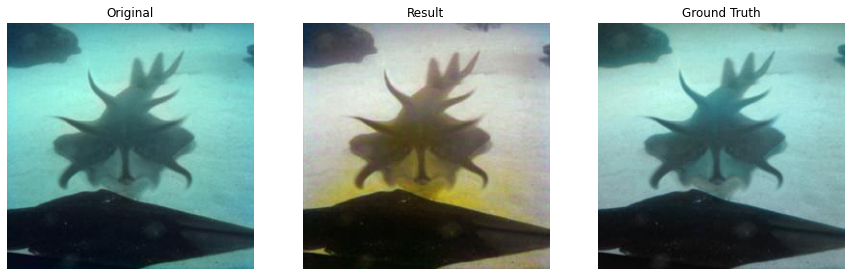

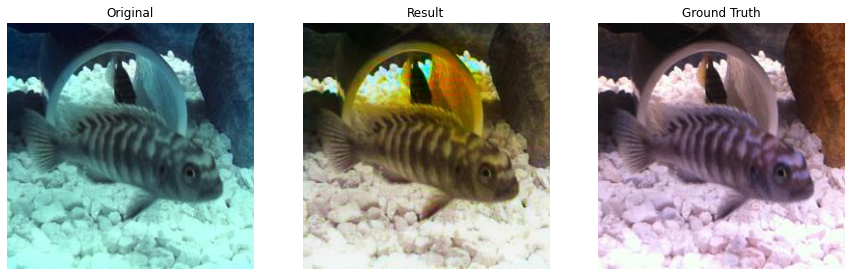

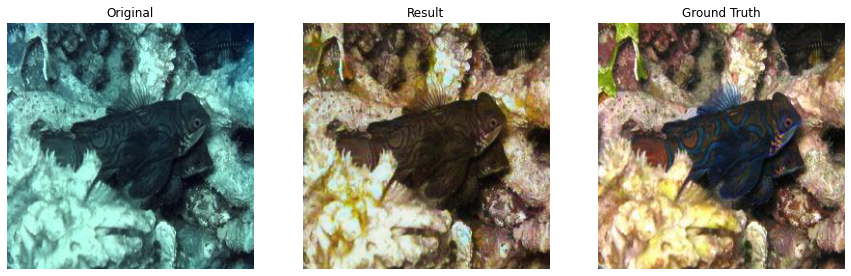

N:500 Folder: dark1


Input   Output  Ground Truth
PSNR   28.5068  28.6690           inf
SSIM    0.8131   0.7897        1.0000
UCIQE   3.4929   6.7607        5.4507
UIQM    2.5034   2.8111        2.8145

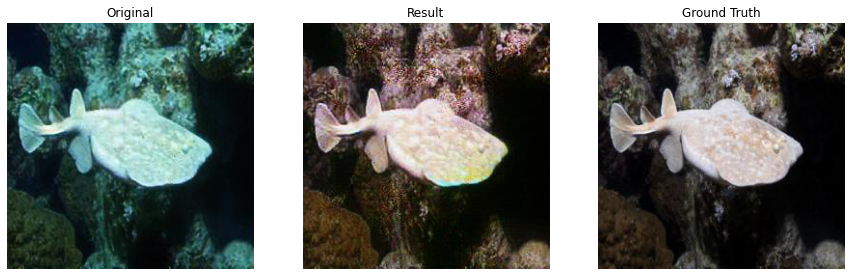

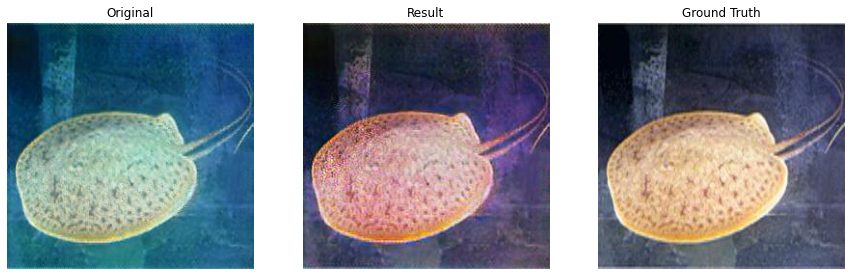

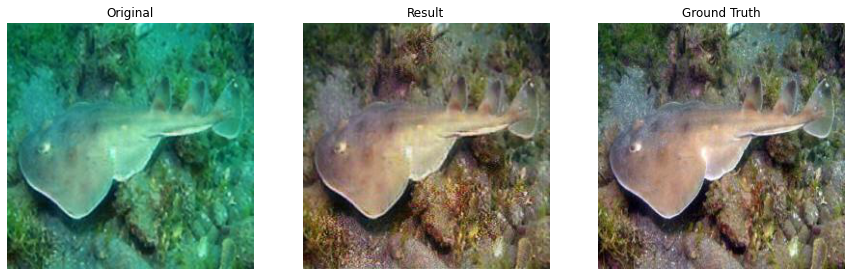

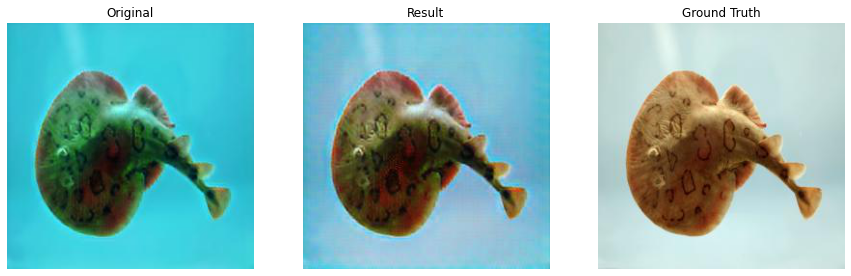

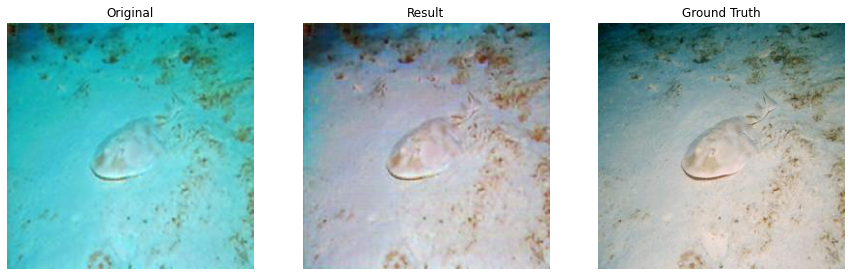

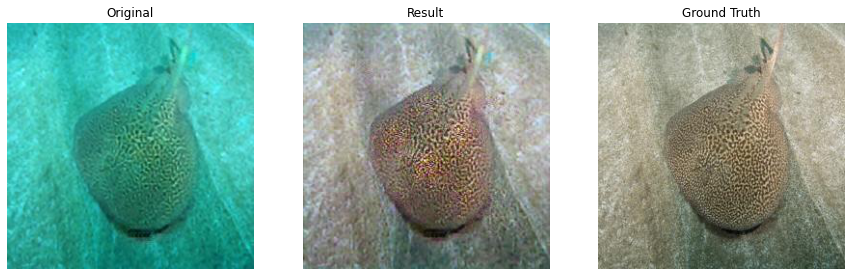

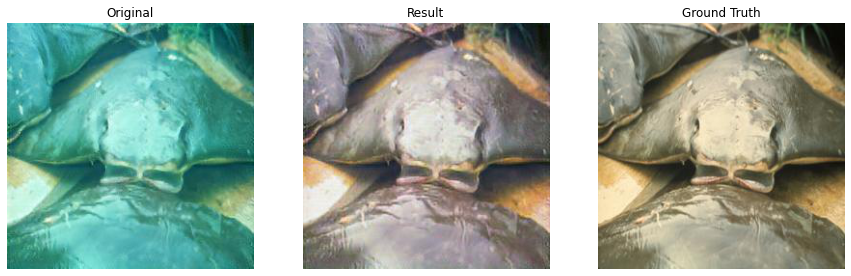

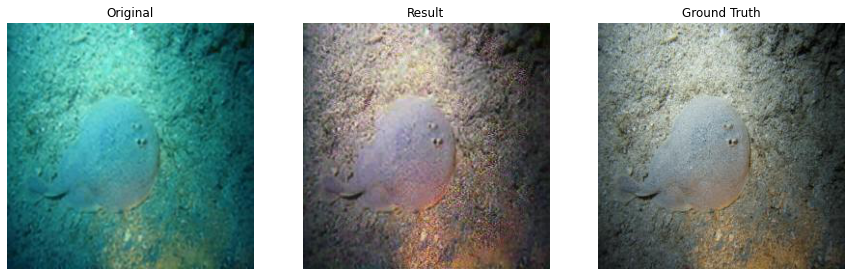

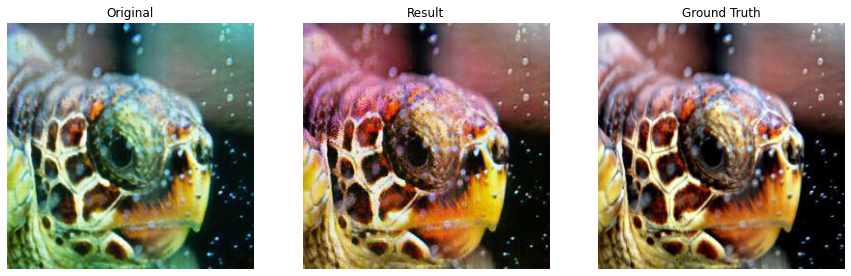

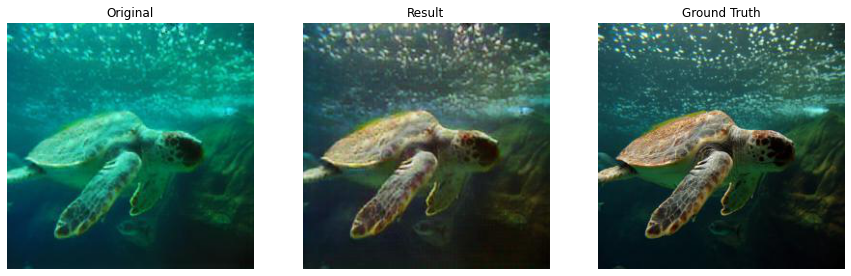

N:500 Folder: image1


Input   Output  Ground Truth
PSNR   28.0141  28.9374           inf
SSIM    0.7065   0.7696        1.0000
UCIQE   4.1567   4.6540        3.7992
UIQM    2.4225   2.9739        2.9473

In [22]:
N = 500 #Number of images from each folder

for folder in folder_list:
    metrics = np.zeros((4,3,N))

    for i,f in enumerate(files[folder][:N]):
#         print(i,f)
        img = plt.imread(os.path.join("data",folder,f))
        img1 = img[:,:256,:]
        output = img[:,256:,:]
        img2 = plt.imread(os.path.join(root,folder,"testB",f))
#         img2 = img2.resize(img1.shape)
#         print(img1.shape, img2.shape)
        
        if(i%50==0):
            plot_images(img1,output,img2)
        metrics[:,:,i] = print_metrics(img1,output,img2, show = False)

    # Get mean metrics
    metrics_mean = np.mean(metrics, axis = 2)

    # Display mean metrics table
    df_metrics_mean = metrics_table(metrics_mean)
    print("N:"+str(N)+ " Folder: "+ folder )
    display(df_metrics_mean.astype(float).round(decimals=4))
    

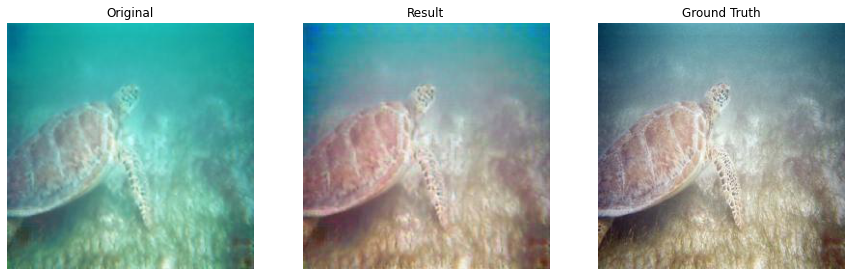

In [23]:
plot_images(img1,output,img2)